In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding #find similar meaning between two words


In [ ]:
from tensorflow.keras.preprocessing.text import one_hot

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/Dataset/review_train.csv')
df.head(10)

,Text,Score,Sentiment
0,"I got a free sample of these once, and now--we...",5,1
1,I used to get this Tea when I lived in Washing...,4,1
2,This is my all time favorite 'grab and go' sna...,5,1
3,This flavor is very good and unexpected. The ...,4,1
4,thrilled to have this assortment as i got the ...,4,1
5,I love the flavor of this coffee. The only dra...,4,1
6,"Like the last review, I have a mixture of dogs...",5,1
7,This is a wonderful and very handy product. I...,5,1
8,"Great value, just be sure to have a place wher...",5,1
9,"I like this flavor, but it kind of reminds me ...",4,1


In [ ]:
df.shape

(14825, 3)

In [ ]:
df['Sentiment'].value_counts(normalize=True)

1    0.844654
0    0.155346
Name: Sentiment, dtype: float64

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(df["Sentiment"]), y= df["Sentiment"])


In [ ]:
class_weight_dict  = dict(enumerate(class_weights))
class_weight_dict

{0: 3.218627876682588, 1: 0.5919581536495767}

In [ ]:
Sentiment_label = np.array(df[['Sentiment']])
print(Sentiment_label)

[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


In [ ]:
#vocabulary size
voc_size=5000

In [ ]:
y=df['Sentiment']
x=df['Text']

In [ ]:
x.head()

0    I got a free sample of these once, and now--we...
1    I used to get this Tea when I lived in Washing...
2    This is my all time favorite 'grab and go' sna...
3    This flavor is very good and unexpected.  The ...
4    thrilled to have this assortment as i got the ...
Name: Text, dtype: object

# One Hot Representation

In [ ]:
massages=x.copy()
print(massages)


0        I got a free sample of these once, and now--we...
1        I used to get this Tea when I lived in Washing...
2        This is my all time favorite 'grab and go' sna...
3        This flavor is very good and unexpected.  The ...
4        thrilled to have this assortment as i got the ...
                               ...                        
14820    This sweetener has a bitter after taste, the p...
14821    I purchased these on a Gold Box Sale, probably...
14822    THIS one is great, good BBQ flavor, moist, che...
14823    I drink red rose with bags and make ice tea wi...
14824    The Quaker Cookie, was a great soft cookie to ...
Name: Text, Length: 14825, dtype: object


In [ ]:
import nltk
import re
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.stem.porter import PorterStemmer   # for stemming the words
ps=PorterStemmer()

In [ ]:
corpus=[]
for i in range(0, len(massages)):
  review= re.sub('[^a-zA-Z]', ' ', massages[i])
  review = review.lower()
  review = review.split()
  review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
  review = ' '.join(review)
  corpus.append(review)

In [ ]:
corpus[0]

'got free sampl subscrib save program much chip fan love slight spici pepper explod textur chip nice greasi manag hit littl salti crunchi crave hit everyonc definit recommend'

In [ ]:
onehot_repr = [one_hot(words, voc_size) for words in corpus]
onehot_repr[0]

[3850,
 152,
 2659,
 3061,
 2599,
 3432,
 710,
 2829,
 1825,
 4975,
 2276,
 3396,
 4400,
 55,
 2833,
 2829,
 2693,
 1527,
 1968,
 3433,
 2340,
 3739,
 920,
 2379,
 3433,
 4828,
 1762,
 3898]

# Embedding Representation

In [ ]:
embedded_docs = pad_sequences(onehot_repr, maxlen=100)

In [ ]:
print(embedded_docs)
print(embedded_docs.shape)

[[   0    0    0 ... 4828 1762 3898]
 [   0    0    0 ... 3223 3309 1109]
 [   0    0    0 ... 2051 2199 1300]
 ...
 [   0    0    0 ...  431 3881 3054]
 [   0    0    0 ...  179 2586 2772]
 [   0    0    0 ... 3067 1279 1236]]
(14825, 100)


In [ ]:
embedding_vector_length=50
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_length, input_length=100) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'],)  
print(model.summary()) 


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           250000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 50)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 270,251
Trainable params: 270,251
Non-trainable params: 0
________________________________________________

In [ ]:
x_final = np.array(embedded_docs)
y_final = np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.3, random_state=1)

In [ ]:
history=model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=32)

Epoch 1/5
325/325 [==============================] - 41s 128ms/step - loss: 0.1379 - accuracy: 0.9500 - val_loss: 0.3457 - val_accuracy: 0.8970
Epoch 2/5
325/325 [==============================] - 41s 127ms/step - loss: 0.1214 - accuracy: 0.9578 - val_loss: 0.3952 - val_accuracy: 0.8939
Epoch 3/5
325/325 [==============================] - 40s 122ms/step - loss: 0.1157 - accuracy: 0.9586 - val_loss: 0.3473 - val_accuracy: 0.8948
Epoch 4/5
325/325 [==============================] - 40s 122ms/step - loss: 0.1088 - accuracy: 0.9611 - val_loss: 0.4023 - val_accuracy: 0.8923
Epoch 5/5
325/325 [==============================] - 39s 122ms/step - loss: 0.0987 - accuracy: 0.9658 - val_loss: 0.3794 - val_accuracy: 0.8928


# Another Approach

In [ ]:
review = df.Text.values
tokenizer = Tokenizer(num_words=10000)  # Tokenizer used for convert text to numeric number
tokenizer.fit_on_texts(review)    #Updates internal vocabulary based on a list of texts.
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(review)  #texts_to_sequences use for replace the words with their assigned numbers 
padded_sequence = pad_sequences(encoded_docs, maxlen=200)    # Use padding to pad the sentences to have equal length

In [ ]:
# print(padded_sequence)
# print(tokenizer.word_index)

In [ ]:
print(review[0])
print(encoded_docs[0])

I got a free sample of these once, and now--we're on the subscribe and save program.  Not much of a chip fan, I love the slight spiciness of these (from the pepper) and the exploded texture of the chip.  It's so nice they're not greasy, and they manage to hit those little salty + crunchy cravings that hit everyonce in a while!  Definitely recommended.
[2, 141, 4, 120, 1152, 7, 27, 328, 3, 90, 1170, 23, 1, 580, 3, 397, 1530, 20, 68, 7, 4, 589, 501, 2, 45, 1, 1098, 4300, 7, 27, 43, 1, 571, 3, 1, 9222, 302, 7, 1, 589, 48, 25, 144, 313, 20, 1266, 3, 22, 3029, 5, 843, 233, 78, 596, 484, 2025, 14, 843, 12, 4, 186, 217, 401]


In [ ]:
print(padded_sequence[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    2  141    4
  120 1152    7   27  328    3   90 1170   23    1  580    3  397 1530
   20   68    7    4  589  501    2   45    1 1098 4300    7   27   43
    1  571    3    1 9222  302    7    1  589   48   25  144  313   20
 1266    3   22 3029    5  843  233   78  596  484 2025   14  843   12
    4 

In [ ]:
embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'],)  
print(model.summary()) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           815744    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 832,395
Trainable params: 832,395
Non-trainable params: 0
__________________________________________________

In [ ]:
history = model.fit(padded_sequence,Sentiment_label,validation_split=0.2, epochs=5, batch_size=32, class_weight = class_weight_dict)

Epoch 1/5
371/371 [==============================] - 89s 231ms/step - loss: 0.5693 - accuracy: 0.7481 - val_loss: 0.4497 - val_accuracy: 0.8283
Epoch 2/5
371/371 [==============================] - 87s 233ms/step - loss: 0.3647 - accuracy: 0.8440 - val_loss: 0.3826 - val_accuracy: 0.8324
Epoch 3/5
371/371 [==============================] - 86s 233ms/step - loss: 0.2811 - accuracy: 0.8844 - val_loss: 0.3502 - val_accuracy: 0.8610
Epoch 4/5
371/371 [==============================] - 87s 233ms/step - loss: 0.2399 - accuracy: 0.9031 - val_loss: 0.3402 - val_accuracy: 0.8695
Epoch 5/5
371/371 [==============================] - 86s 232ms/step - loss: 0.1975 - accuracy: 0.9221 - val_loss: 0.2653 - val_accuracy: 0.8965


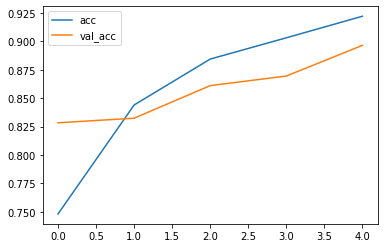

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

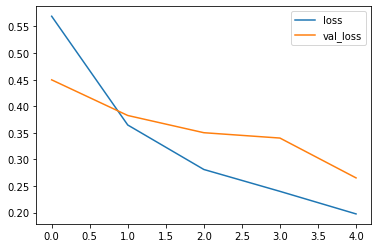

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [ ]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", prediction)

In [ ]:
test_sentence1 = "The food was not tasty"
predict_sentiment(test_sentence1)

test_sentence2 = "not good"
predict_sentiment(test_sentence2)

Predicted label:  0
Predicted label:  0
